In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
# produced by the notebook "classify all features extracted from all the runs"
SEQUENCES_WITH_SPECIES_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequences-with-species-df.pkl'
# copied from BAM
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"
EXPERIMENT_METRICS_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl"


In [3]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

In [4]:
get_percolator_run_mapping(MAPPING_FILE_NAME)

[(0, '190719_Hela_Ecoli_1to3_06'),
 (1, '190719_Hela_Ecoli_1to1_07'),
 (2, '190719_Hela_Ecoli_1to1_09'),
 (3, '190719_Hela_Ecoli_1to3_09'),
 (4, '190719_Hela_Ecoli_1to3_05'),
 (5, '190719_Hela_Ecoli_1to3_01'),
 (6, '190719_Hela_Ecoli_1to1_03'),
 (7, '190719_Hela_Ecoli_1to3_08'),
 (8, '190719_Hela_Ecoli_1to1_10'),
 (9, '190719_Hela_Ecoli_1to3_07'),
 (10, '190719_Hela_Ecoli_1to1_08'),
 (11, '190719_Hela_Ecoli_1to1_01'),
 (12, '190719_Hela_Ecoli_1to3_04'),
 (13, '190719_Hela_Ecoli_1to3_03'),
 (14, '190719_Hela_Ecoli_1to3_10'),
 (15, '190719_Hela_Ecoli_1to1_04'),
 (16, '190719_Hela_Ecoli_1to1_02'),
 (17, '190719_Hela_Ecoli_1to3_02'),
 (18, '190719_Hela_Ecoli_1to1_05'),
 (19, '190719_Hela_Ecoli_1to1_06')]

In [5]:
sequences_with_species_df = pd.read_pickle(SEQUENCES_WITH_SPECIES_FILE_NAME)

In [6]:
experiment_metrics_for_library_sequences_df = pd.read_pickle(EXPERIMENT_METRICS_FILE_NAME)

In [7]:
# unpack the TFD-extracted attributes from each sequence
attributes = []
attribute_names = [key for key in sorted(experiment_metrics_for_library_sequences_df.iloc[0].attributes)]

for row in experiment_metrics_for_library_sequences_df.itertuples():
    # target metric valuesa
    d = row.attributes
    if (d is not None):
        # check whether any of the values are None
        all_not_none = True
        for k,v in d.items(): 
            if d[k] is None:
                all_not_none = False
                break
        # add the attributes to the collection
        if all_not_none == True:
            l = []
            l.append(row.sequence)
            l.append(row.charge)
            l.append(row.file_idx)
            l += [d[key] for key in sorted(d)]
            attributes.append(tuple(l))

columns = ['sequence','charge','file_idx']
columns += attribute_names

attributes_as_extracted_df = pd.DataFrame(attributes, columns=columns)

In [8]:
attributes_as_extracted_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_saturation_adjusted_flag',
       'intensity_top_3', 'isotope_idx_not_in_saturation', 'monoisotopic_mz',
       'rt_apex', 'scan_apex'],
      dtype='object')

In [9]:
sequences_with_attributes_df = pd.merge(attributes_as_extracted_df, sequences_with_species_df, how='inner', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])
sequences_with_attributes_df['log_intensity'] = np.log2(sequences_with_attributes_df.intensity_saturation_adjusted)


In [10]:
sequences_with_attributes_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_saturation_adjusted_flag',
       'intensity_top_3', 'isotope_idx_not_in_saturation', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity'],
      dtype='object')

In [11]:
# find the experiment-wide means and std devs
experiment_intensities_l = []
for group_name,group_df in sequences_with_attributes_df.groupby(['sequence','charge'], as_index=False):
    number_of_runs_for_sequence = len(group_df)
    # intensity
    experiment_intensity_mean = np.mean(group_df.log_intensity)
    experiment_intensity_std_dev = np.std(group_df.log_intensity)
    # rt
    experiment_rt_mean = np.mean(group_df.rt_apex)
    experiment_rt_std_dev = np.std(group_df.rt_apex)
    # scan
    experiment_scan_mean = np.mean(group_df.scan_apex)
    experiment_scan_std_dev = np.std(group_df.scan_apex)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_intensities_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence))

experiment_intensities_df = pd.DataFrame(experiment_intensities_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','number_of_runs_for_sequence'])


In [12]:
sequences_df = pd.merge(sequences_with_attributes_df, experiment_intensities_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [13]:
len(sequences_df[sequences_df.human == False])

691

In [14]:
sequences_df[(sequences_df.number_of_runs_for_sequence > 15) & (sequences_df.human == False)].sample(15).sort_values(by=['sequence','charge','intensity_saturation_adjusted'], inplace=False)


,sequence,charge,file_idx,intensity_all_points,intensity_saturation_adjusted,intensity_saturation_adjusted_flag,intensity_top_3,isotope_idx_not_in_saturation,monoisotopic_mz,rt_apex,...,batch,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
2006,AEIGHVSAER,2,11,7024,173245,0,267,0,534.776494,228.585164,...,1to1,False,17.402454,18.033219,0.422843,224.841159,2.229535,855.693180,4.137453,20
3432,GLPIPVVITVYADR,2,19,159466,389569,0,4504,0,756.942123,1032.672607,...,1to1,False,18.571519,19.604430,0.991587,1033.183268,4.377271,570.685721,23.978768,20
1864,HGLHYVELR,2,10,7811,164792,0,288,0,562.303420,345.684611,...,1to1,False,17.330287,17.108838,0.471603,340.026199,5.553696,746.357229,13.897384,19
1929,HNDLENVGYTAR,2,11,117413,541179,0,3536,0,694.831202,349.102082,...,1to1,False,19.045746,19.636852,0.734254,344.936381,3.213506,645.540334,3.310686,20
2168,IGVM[15.9949]FGNPETTTGGNALK,2,12,10716,238316,0,418,0,911.954501,635.726633,...,1to3,False,17.862516,17.664347,0.250356,634.690777,4.711926,341.908593,3.991573,19
1221,IIHPMGEIDAMEFLINK,2,6,1787,157144,0,170,0,986.005862,978.803548,...,1to1,False,17.261728,16.886191,0.207182,978.484304,5.265955,198.973397,6.578992,17
647,KNQLEVMR,2,3,30862,46573,0,2302,0,509.278934,280.521815,...,1to3,False,15.507206,15.646843,0.421454,283.317683,3.054066,895.998391,4.855938,20
2184,LFEAAAQCSGILAGCTPEEEK,2,12,47112,121966,0,1258,0,1141.029640,694.215724,...,1to3,False,16.896120,15.875210,0.583086,696.325667,2.673544,103.418127,4.500526,20
1521,MAAEEFTQAM[15.9949]NGVR,2,8,3739,104291,0,242,0,785.851747,699.034842,...,1to1,False,16.670255,16.373429,0.492647,720.574964,14.618013,542.744574,24.461401,19
1285,MLLPDTVGTGGDSHTR,3,7,7780,8943,0,466,0,552.940299,528.401631,...,1to3,False,13.126543,13.902496,0.561596,533.078111,3.988129,830.628758,13.098982,19


In [15]:
sequences_df.classed_as.unique()

array(['target'], dtype=object)

In [60]:
selected_sequence = 'TPPIDGIDHPK'
selected_sequence_charge = 2

In [61]:
selected_sequence_df = sequences_df[(sequences_df.sequence == selected_sequence) & (sequences_df.charge == selected_sequence_charge)].copy()

In [62]:
selected_sequence_df.sort_values(by=['batch','run_name'], inplace=True)

In [63]:
selected_sequence_df

,sequence,charge,file_idx,intensity_all_points,intensity_saturation_adjusted,intensity_saturation_adjusted_flag,intensity_top_3,isotope_idx_not_in_saturation,monoisotopic_mz,rt_apex,...,batch,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
2004,TPPIDGIDHPK,2,11,1613,558398,1,231,1,595.315568,379.090591,...,1to1,False,19.090934,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18
2871,TPPIDGIDHPK,2,16,11866,553813,1,644,1,595.315354,371.635761,...,1to1,False,19.079039,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18
1130,TPPIDGIDHPK,2,6,4074,568671,1,446,1,595.315432,369.192680,...,1to1,False,19.117235,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18
3223,TPPIDGIDHPK,2,18,11927,536828,1,452,1,595.315540,371.717707,...,1to1,False,19.034100,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18
3402,TPPIDGIDHPK,2,19,4782,507117,1,399,1,595.315462,366.193837,...,1to1,False,18.951959,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18
248,TPPIDGIDHPK,2,1,15019,514822,1,457,1,595.315466,369.576807,...,1to1,False,18.973714,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18
1826,TPPIDGIDHPK,2,10,2293,515284,1,280,1,595.315479,364.974534,...,1to1,False,18.975008,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18
420,TPPIDGIDHPK,2,2,15966,513736,0,503,0,595.315293,369.244496,...,1to1,False,18.970668,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18
1476,TPPIDGIDHPK,2,8,12544,505077,1,536,1,595.315448,368.838019,...,1to1,False,18.946144,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18
946,TPPIDGIDHPK,2,5,19084,469045,0,532,0,595.315410,367.041421,...,1to3,False,18.839367,18.747902,0.444214,367.814132,3.639906,748.057116,9.633238,18


In [64]:
selected_sequence_1to1_df = selected_sequence_df[selected_sequence_df.batch == '1to1']
selected_sequence_1to3_df = selected_sequence_df[selected_sequence_df.batch == '1to3']

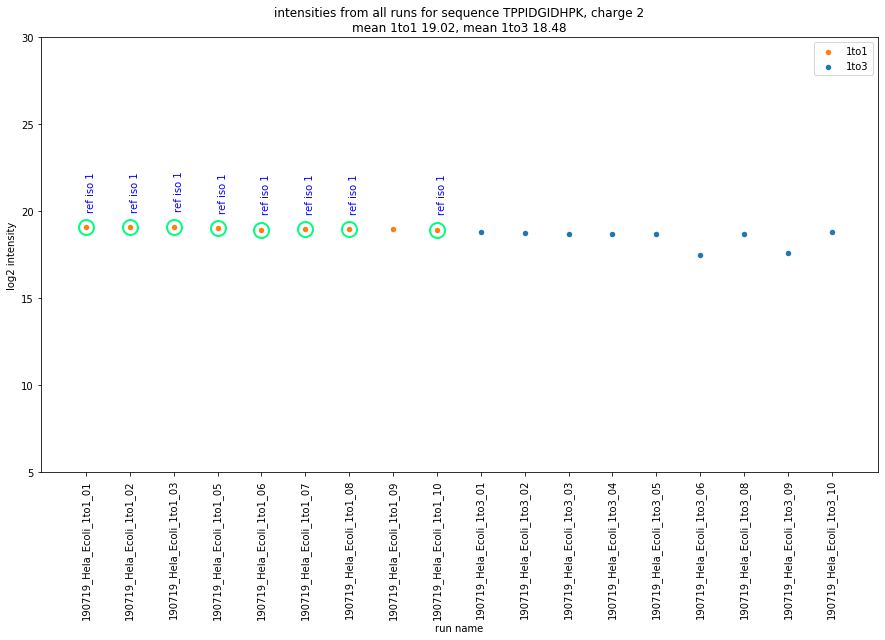

In [65]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

mean_1to1 = round(np.mean(np.log2(selected_sequence_1to1_df.intensity_saturation_adjusted)), 2)
mean_1to3 = round(np.mean(np.log2(selected_sequence_1to3_df.intensity_saturation_adjusted)), 2)

plt.title('intensities from all runs for sequence {}, charge {}\nmean 1to1 {}, mean 1to3 {}'.format(selected_sequence, selected_sequence_charge, mean_1to1, mean_1to3))

ax1.scatter(selected_sequence_1to1_df.run_name, np.log2(selected_sequence_1to1_df.intensity_saturation_adjusted), marker='o', color='tab:orange', lw=0, s=30, alpha=1.0, label='1to1')
ax1.scatter(selected_sequence_1to3_df.run_name, np.log2(selected_sequence_1to3_df.intensity_saturation_adjusted), marker='o', color='tab:blue', lw=0, s=30, alpha=1.0, label='1to3')

# highlight whether a point was adjusted for saturation
adj_sat_1to1 = selected_sequence_1to1_df[(selected_sequence_1to1_df.isotope_idx_not_in_saturation > 0)]
ax1.plot(adj_sat_1to1.run_name, np.log2(adj_sat_1to1.intensity_saturation_adjusted), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

adj_sat_1to3 = selected_sequence_1to3_df[(selected_sequence_1to3_df.isotope_idx_not_in_saturation > 0)]
ax1.plot(adj_sat_1to3.run_name, np.log2(adj_sat_1to3.intensity_saturation_adjusted), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

# show which isotope was used as a reference
text_style = dict(size=10, color='blue')
for idx,row in adj_sat_1to1.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity_saturation_adjusted)+1, "ref iso {}".format(row.isotope_idx_not_in_saturation), **text_style, rotation=90)
for idx,row in adj_sat_1to3.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity_saturation_adjusted)+1, "ref iso {}".format(row.isotope_idx_not_in_saturation), **text_style, rotation=90)

plt.xlabel('run name')
plt.ylabel('log2 intensity')
plt.legend(loc='best')

# plt.xlim((0,50))
plt.ylim((5,30))
plt.xticks(rotation=90)

plt.show()